## Columnes
genre: The genre in which the track belongs.

artist_name: The artists' names who performed the track

track_name: Name of the track

track_id: The Spotify ID for the track

popularity: The popularity of a track is a value between 0 and 100

acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic

danceability: Danceability describes how suitable a track is for dancing based

duration_ms: The track length in milliseconds

energy: Measure of intensity and activity from 0.0 to 1.0

instrumentalness: Predicts whether a track contains no vocals (nearer 1=no vocals)

key: The key the track is in

liveness: Detects the presence of an audience in the recording (higher 0.8=live)

loudness: The overall loudness of a track in decibels (dB)

mode: Mode indicates the scale (major or minor) of a track

speechiness: Speechiness detects the presence of spoken words in a track

tempo: The overall estimated tempo of a track in beats per minute

time_signature: An estimated time signature

valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track

In [1]:
##A)Carregar llibreries
import pandas as pd ###py -m pip install pandas
import numpy as np ###py -m pip install numypy

from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD ###py -m pip install scikit-learn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, HDBSCAN, DBSCAN, MiniBatchKMeans 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

from yellowbrick.cluster import KElbowVisualizer ##py -m pip install yellowbrick

import seaborn as sns ##py -m pip install seaborn

import random

import matplotlib.pyplot as plt ##py -m pip install matplotlib

# B) Carregar dataset

In [2]:
##B)Carregar el dataset
df = pd.read_csv('SpotifyFeatures.csv')
#print(df.head()) #Mostra 5 rows
print(df.info()) #Mostra el tipus de columns: df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

# C) Preparar dades

In [3]:
##C)Preparar dades
#1) Tractar duplicats
#Quantitat duplicats
print("Quantitat de dupplicats:", df.duplicated(subset="track_id", keep="first").sum())
#print(df[df.duplicated(subset="track_id", keep=False)]) Veure files dels duplicats

#Treure duplicats (files)
df.drop_duplicates(subset="track_id", keep="first", inplace=True)
print("Quantitat de dupplicats després:", df.duplicated(subset="track_id", keep="first").sum())
print("New shape sense duplicats:", df.shape)

Quantitat de dupplicats: 55951
Quantitat de dupplicats després: 0
New shape sense duplicats: (176774, 18)


In [4]:
#2) Corretgir valors errònis (impossibles)
#Comprovar valors de key, mode i time_signature
#print("Key values:", df['key'].value_counts())
#print("Mode values:", df["mode"].value_counts())
#print("Time_signature values:", df["time_signature"].value_counts())
#print("Genre values::", df["genre"].value_counts())

#Eliminar key: "0/4" (impossible)
print("Quantitat de '0/4'abans:", (df["time_signature"] == "0/4").sum()) #Quantitat key: "0/4"
df = df[df["time_signature"] != "0/4"]
print("Quantitat de '0/4' després:", (df["time_signature"] == "0/4").sum())
print("New shape sense '0/4':", df.shape)

#Eliminar NaN
print("Quantitat de Nan abans:", df.isna().sum().sum()) #Quantitat Nan en tot df
#print("NaN per features:", df.isna().sum())
df.dropna(axis=0, inplace=True) #
print("Quantitat de Nan després:", df.isna().sum().sum())
print("New shape sense Nan:", df.shape)

Quantitat de '0/4'abans: 6
Quantitat de '0/4' després: 0
New shape sense '0/4': (176768, 18)
Quantitat de Nan abans: 1
Quantitat de Nan després: 0
New shape sense Nan: (176767, 18)


In [5]:
#3) Eliminar columnes 
#Reiniciar index en dataframe
df.reset_index(drop=True, inplace=True)

#Guardar columnes: 'track_name', 'artist_name'
track_name = df[["track_name"]]
artist_name = df[["artist_name"]]

#Drop olumnes: 'artist_name','track_name','track_id 
df.drop(['artist_name','track_name','track_id'], axis=1, inplace=True) #Elimina les columnes modificant df og
print(f"Nova shape sense artist_name, track_name, track_id: {df.shape}") #Mostra rowsxcolumns

num_col = df.select_dtypes(exclude="object").columns
cat_col = df.select_dtypes(include="object").columns

Nova shape sense artist_name, track_name, track_id: (176767, 15)


In [6]:
#4)Codificar columnes no numèriques
"""
#METODE0 Totes features amb frequencia
freq = df["key"].value_counts(normalize=True)
df["key"] = df["key"].map(freq)
#Codificar columna mode 
freq = df["mode"].value_counts(normalize=True)
df["mode"] = df["mode"].map(freq)
#Codificar columna time_signature
freq = df["time_signature"].value_counts(normalize=True)
df["time_signature"] = df["time_signature"].map(freq)
#Codificar columna genre
freq = df["genre"].value_counts(normalize=True)
df["genre"] = df["genre"].map(freq)
"""

#METODE1 Totes features amb OneHotEncoder 
df1 = df.copy(deep=True)
df_temp = df1[['genre','key', 'mode', 'time_signature']].copy()
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_array = enc.fit_transform(df_temp)
feature_names = enc.get_feature_names_out(['genre','key', 'mode', 'time_signature'])
encoded_df = pd.DataFrame(encoded_array, columns=feature_names, index=df1.index)
df1 = pd.concat([df1.drop(['genre','key', 'mode', 'time_signature'], axis=1), encoded_df], axis=1)
print("Nova shape df1:", df1.shape)
print("Noves columnas:", df1.columns)

#METODE2 Genre amb OneHotEncoder i resta amb Diccionari ordenat
df2 = df.copy(deep=True)
mode_dict = {'Major' : 1, 'Minor' : 0}
key_dict = {'C' : 1, 'C#' : 2, 'D' : 3, 'D#' : 4, 'E' : 5, 'F' : 6, 
        'F#' : 7, 'G' : 9, 'G#' : 10, 'A' : 11, 'A#' : 12, 'B' : 12}
time_signature_dict = {'1/4' : 1, '3/4' : 3, '4/4' :4, "5/4": 5}
#Codificar columna key 
df2["key"] = df2["key"].map(key_dict)
#Codificar columna mode 
df2["mode"] = df2["mode"].map(mode_dict)
#Codificar columna time_signature
df2["time_signature"] = df2["time_signature"].map(time_signature_dict)
#Codificar columna genre
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_temp = df2[['genre']].copy()
encoded_array = enc.fit_transform(df_temp)
feature_names = enc.get_feature_names_out(['genre'])
encoded_df = pd.DataFrame(encoded_array, columns=feature_names, index=df1.index)
df2 = pd.concat([df2.drop(['genre'], axis=1), encoded_df], axis=1)
print("Nova shape df2:", df2.shape)
print("Noves columnas:", df2.columns)

#METODE3 Genre amb OneHotEncoder i resta amb frequencia
df3 = df.copy(deep=True)
freq = df3["key"].value_counts(normalize=True)
df3["key"] = df3["key"].map(freq)
#Codificar columna mode 
freq = df["mode"].value_counts(normalize=True)
df3["mode"] = df3["mode"].map(freq)
#Codificar columna time_signature
freq = df3["time_signature"].value_counts(normalize=True)
df3["time_signature"] = df3["time_signature"].map(freq)
#Codificar columna genre
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_temp = df3[['genre']].copy()
encoded_array = enc.fit_transform(df_temp)
feature_names = enc.get_feature_names_out(['genre'])
encoded_df = pd.DataFrame(encoded_array, columns=feature_names, index=df3.index)
df3 = pd.concat([df3.drop(['genre'], axis=1), encoded_df], axis=1)
print("Nova shape df3:", df3.shape)
print("Noves columnas:", df3.columns)

Nova shape df1: (176767, 56)
Noves columnas: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'genre_A Capella', 'genre_Alternative', 'genre_Anime',
       'genre_Blues', 'genre_Children's Music', 'genre_Children’s Music',
       'genre_Classical', 'genre_Comedy', 'genre_Country', 'genre_Dance',
       'genre_Electronic', 'genre_Folk', 'genre_Hip-Hop', 'genre_Indie',
       'genre_Jazz', 'genre_Movie', 'genre_Opera', 'genre_Pop', 'genre_R&B',
       'genre_Rap', 'genre_Reggae', 'genre_Reggaeton', 'genre_Rock',
       'genre_Ska', 'genre_Soul', 'genre_Soundtrack', 'genre_World', 'key_A',
       'key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E',
       'key_F', 'key_F#', 'key_G', 'key_G#', 'mode_Major', 'mode_Minor',
       'time_signature_1/4', 'time_signature_3/4', 'time_signature_4/4',
       'time_signature_5/4'],
      dtype='object')
Nova shape df

(array([[<Axes: title={'center': 'popularity'}>,
         <Axes: title={'center': 'acousticness'}>,
         <Axes: title={'center': 'danceability'}>,
         <Axes: title={'center': 'duration_ms'}>,
         <Axes: title={'center': 'energy'}>,
         <Axes: title={'center': 'instrumentalness'}>,
         <Axes: title={'center': 'liveness'}>],
        [<Axes: title={'center': 'loudness'}>,
         <Axes: title={'center': 'speechiness'}>,
         <Axes: title={'center': 'tempo'}>,
         <Axes: title={'center': 'valence'}>,
         <Axes: title={'center': 'genre_A Capella'}>,
         <Axes: title={'center': 'genre_Alternative'}>,
         <Axes: title={'center': 'genre_Anime'}>],
        [<Axes: title={'center': 'genre_Blues'}>,
         <Axes: title={'center': "genre_Children's Music"}>,
         <Axes: title={'center': 'genre_Children’s Music'}>,
         <Axes: title={'center': 'genre_Classical'}>,
         <Axes: title={'center': 'genre_Comedy'}>,
         <Axes: title={'ce

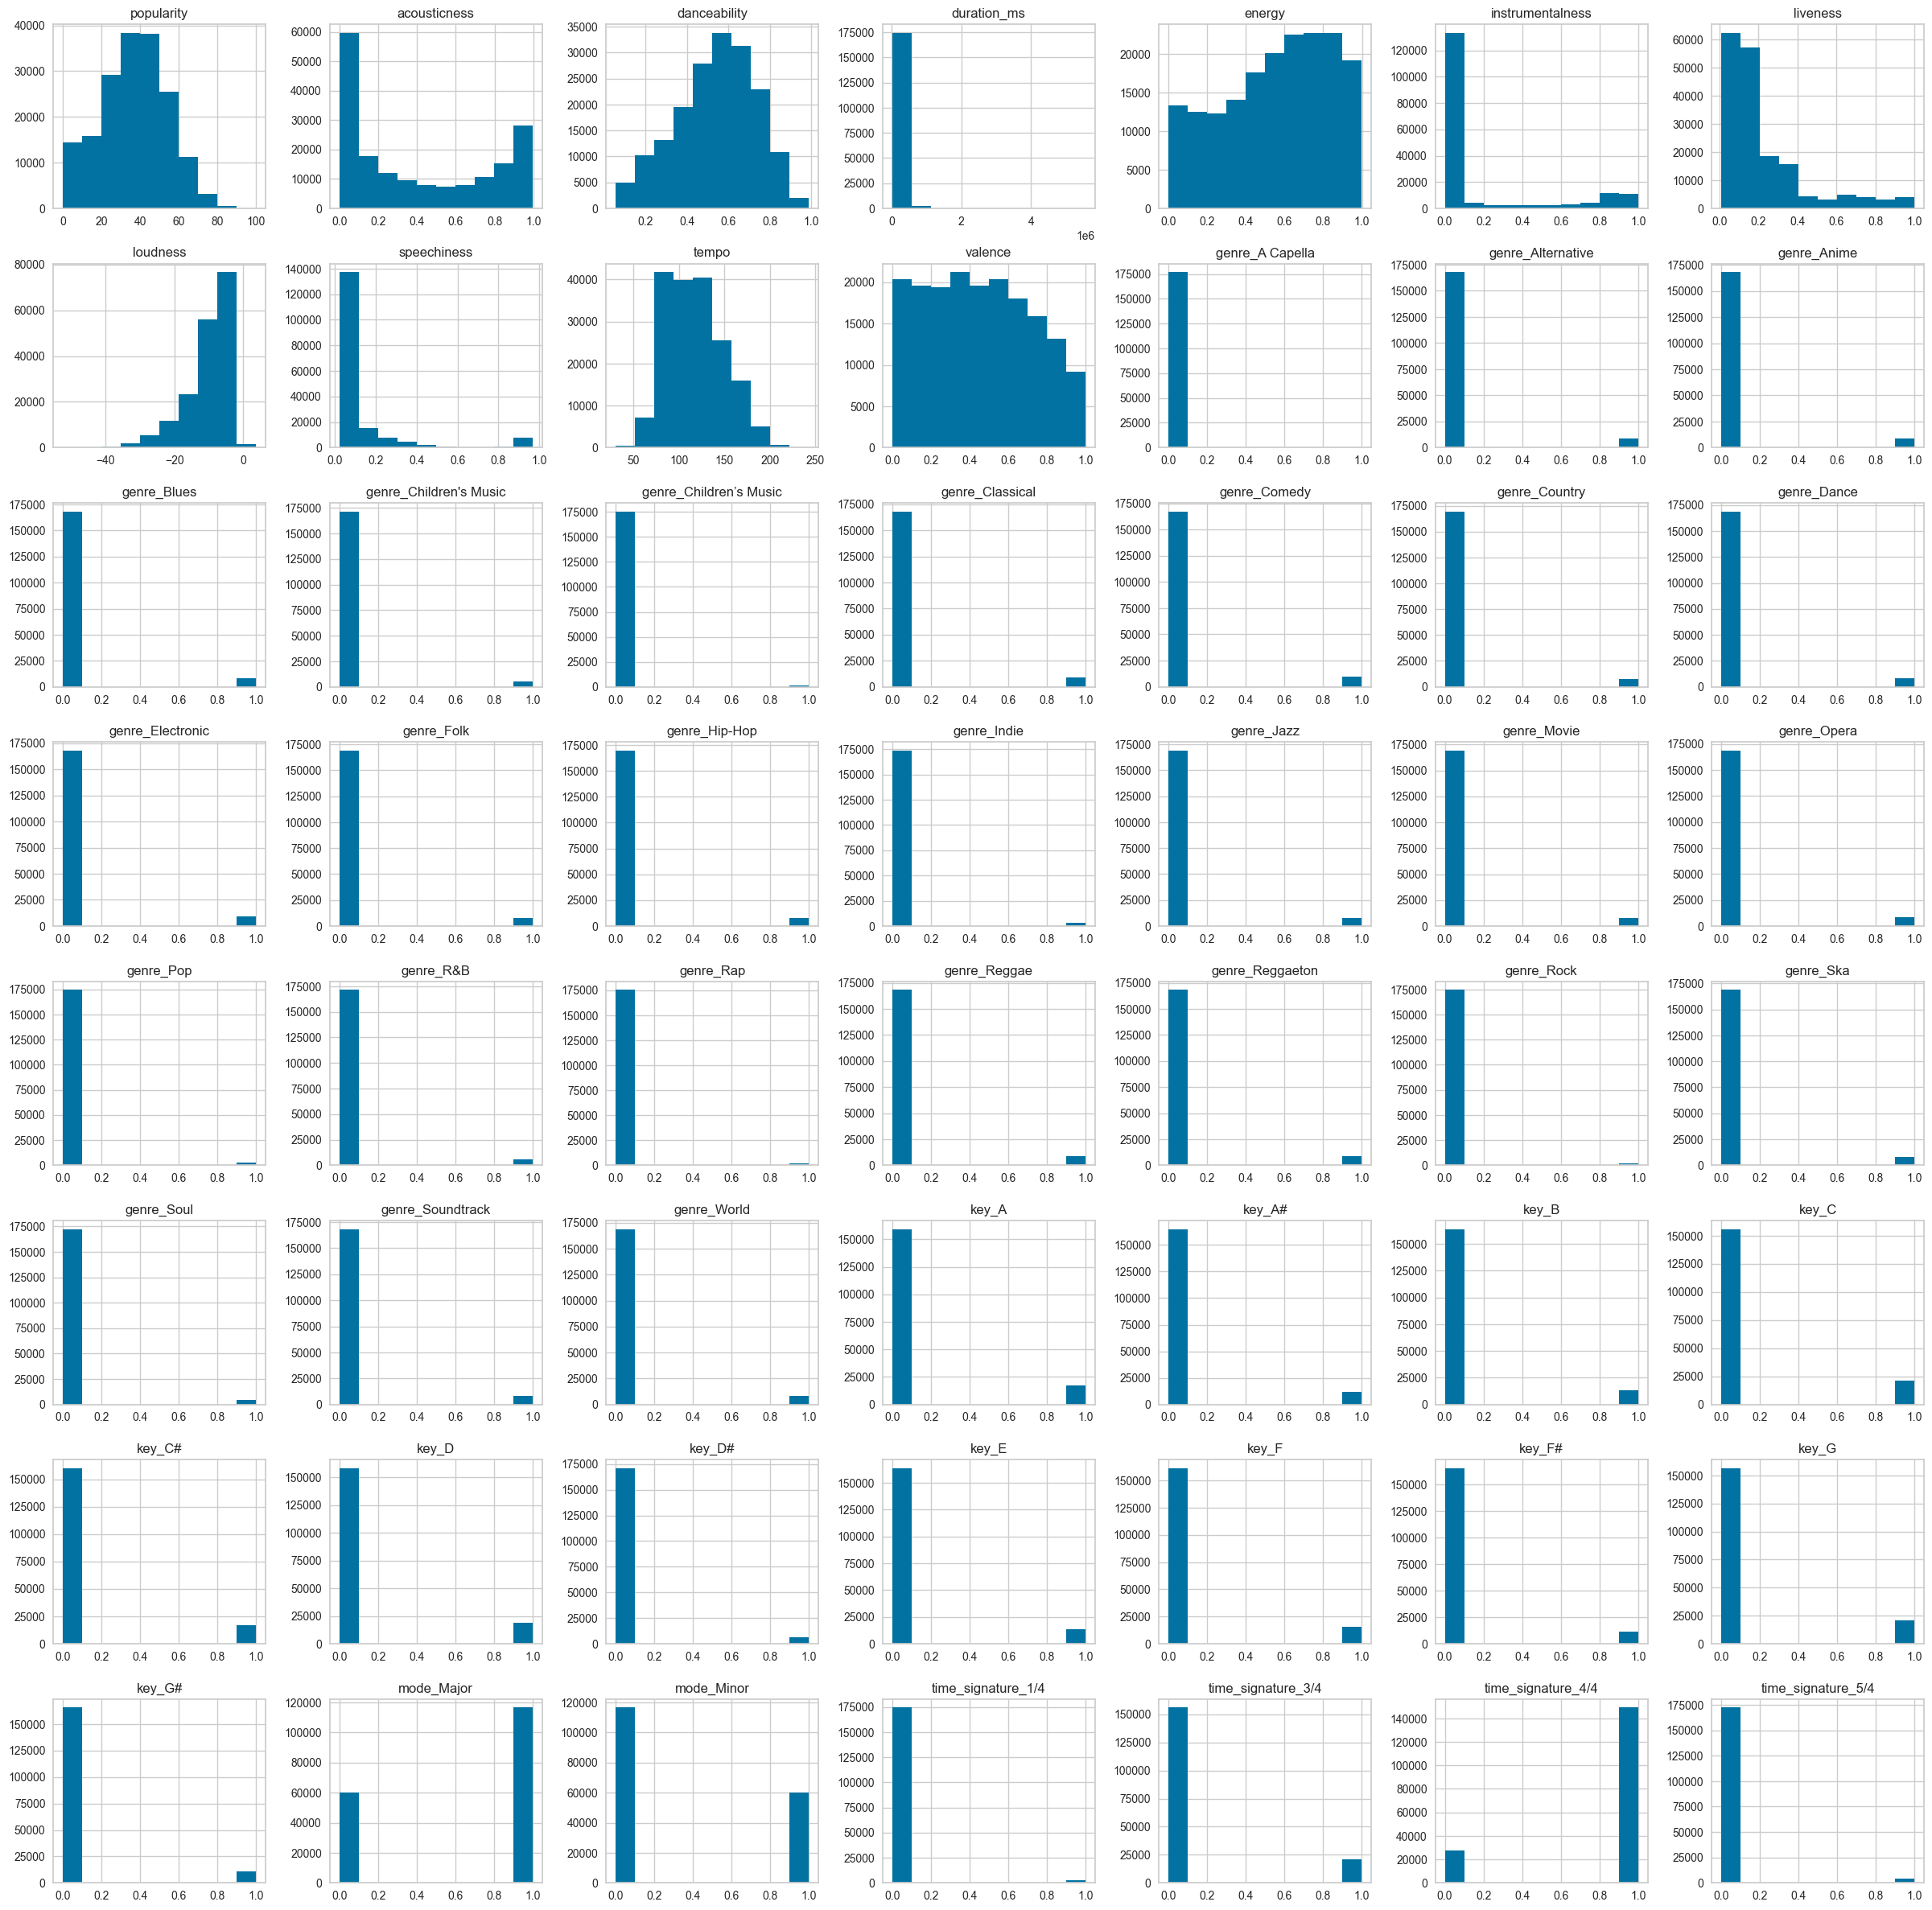

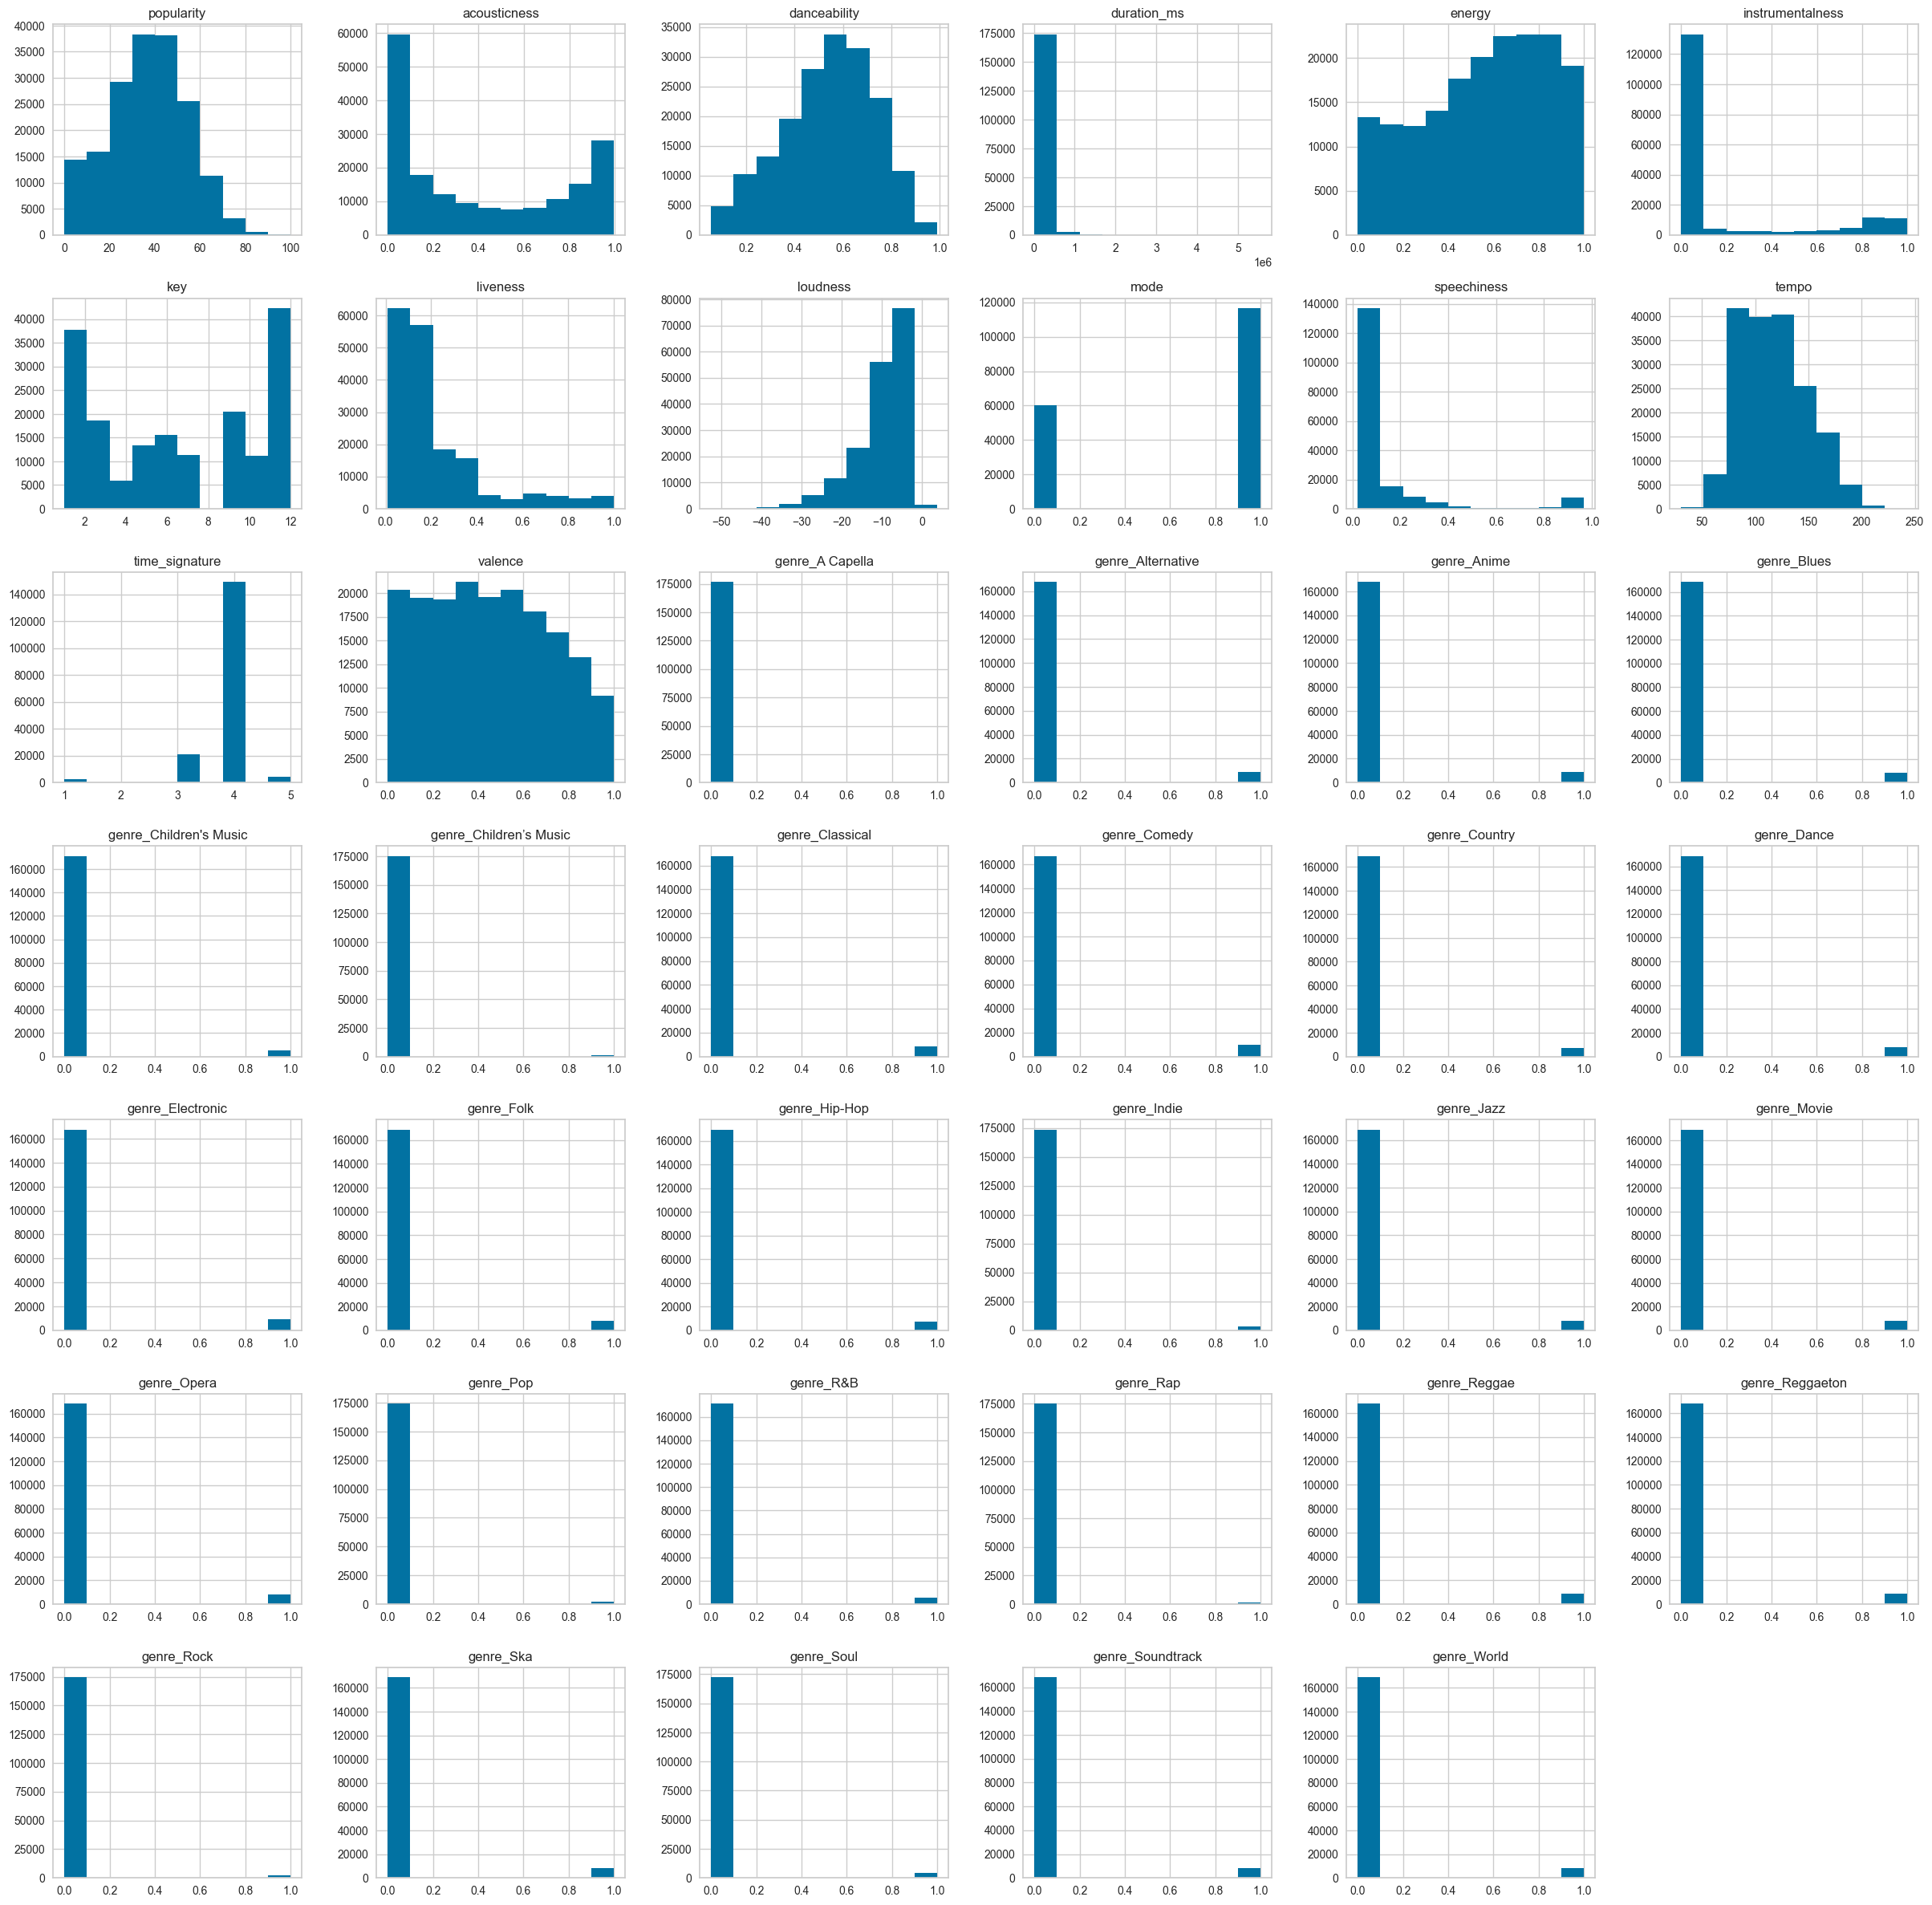

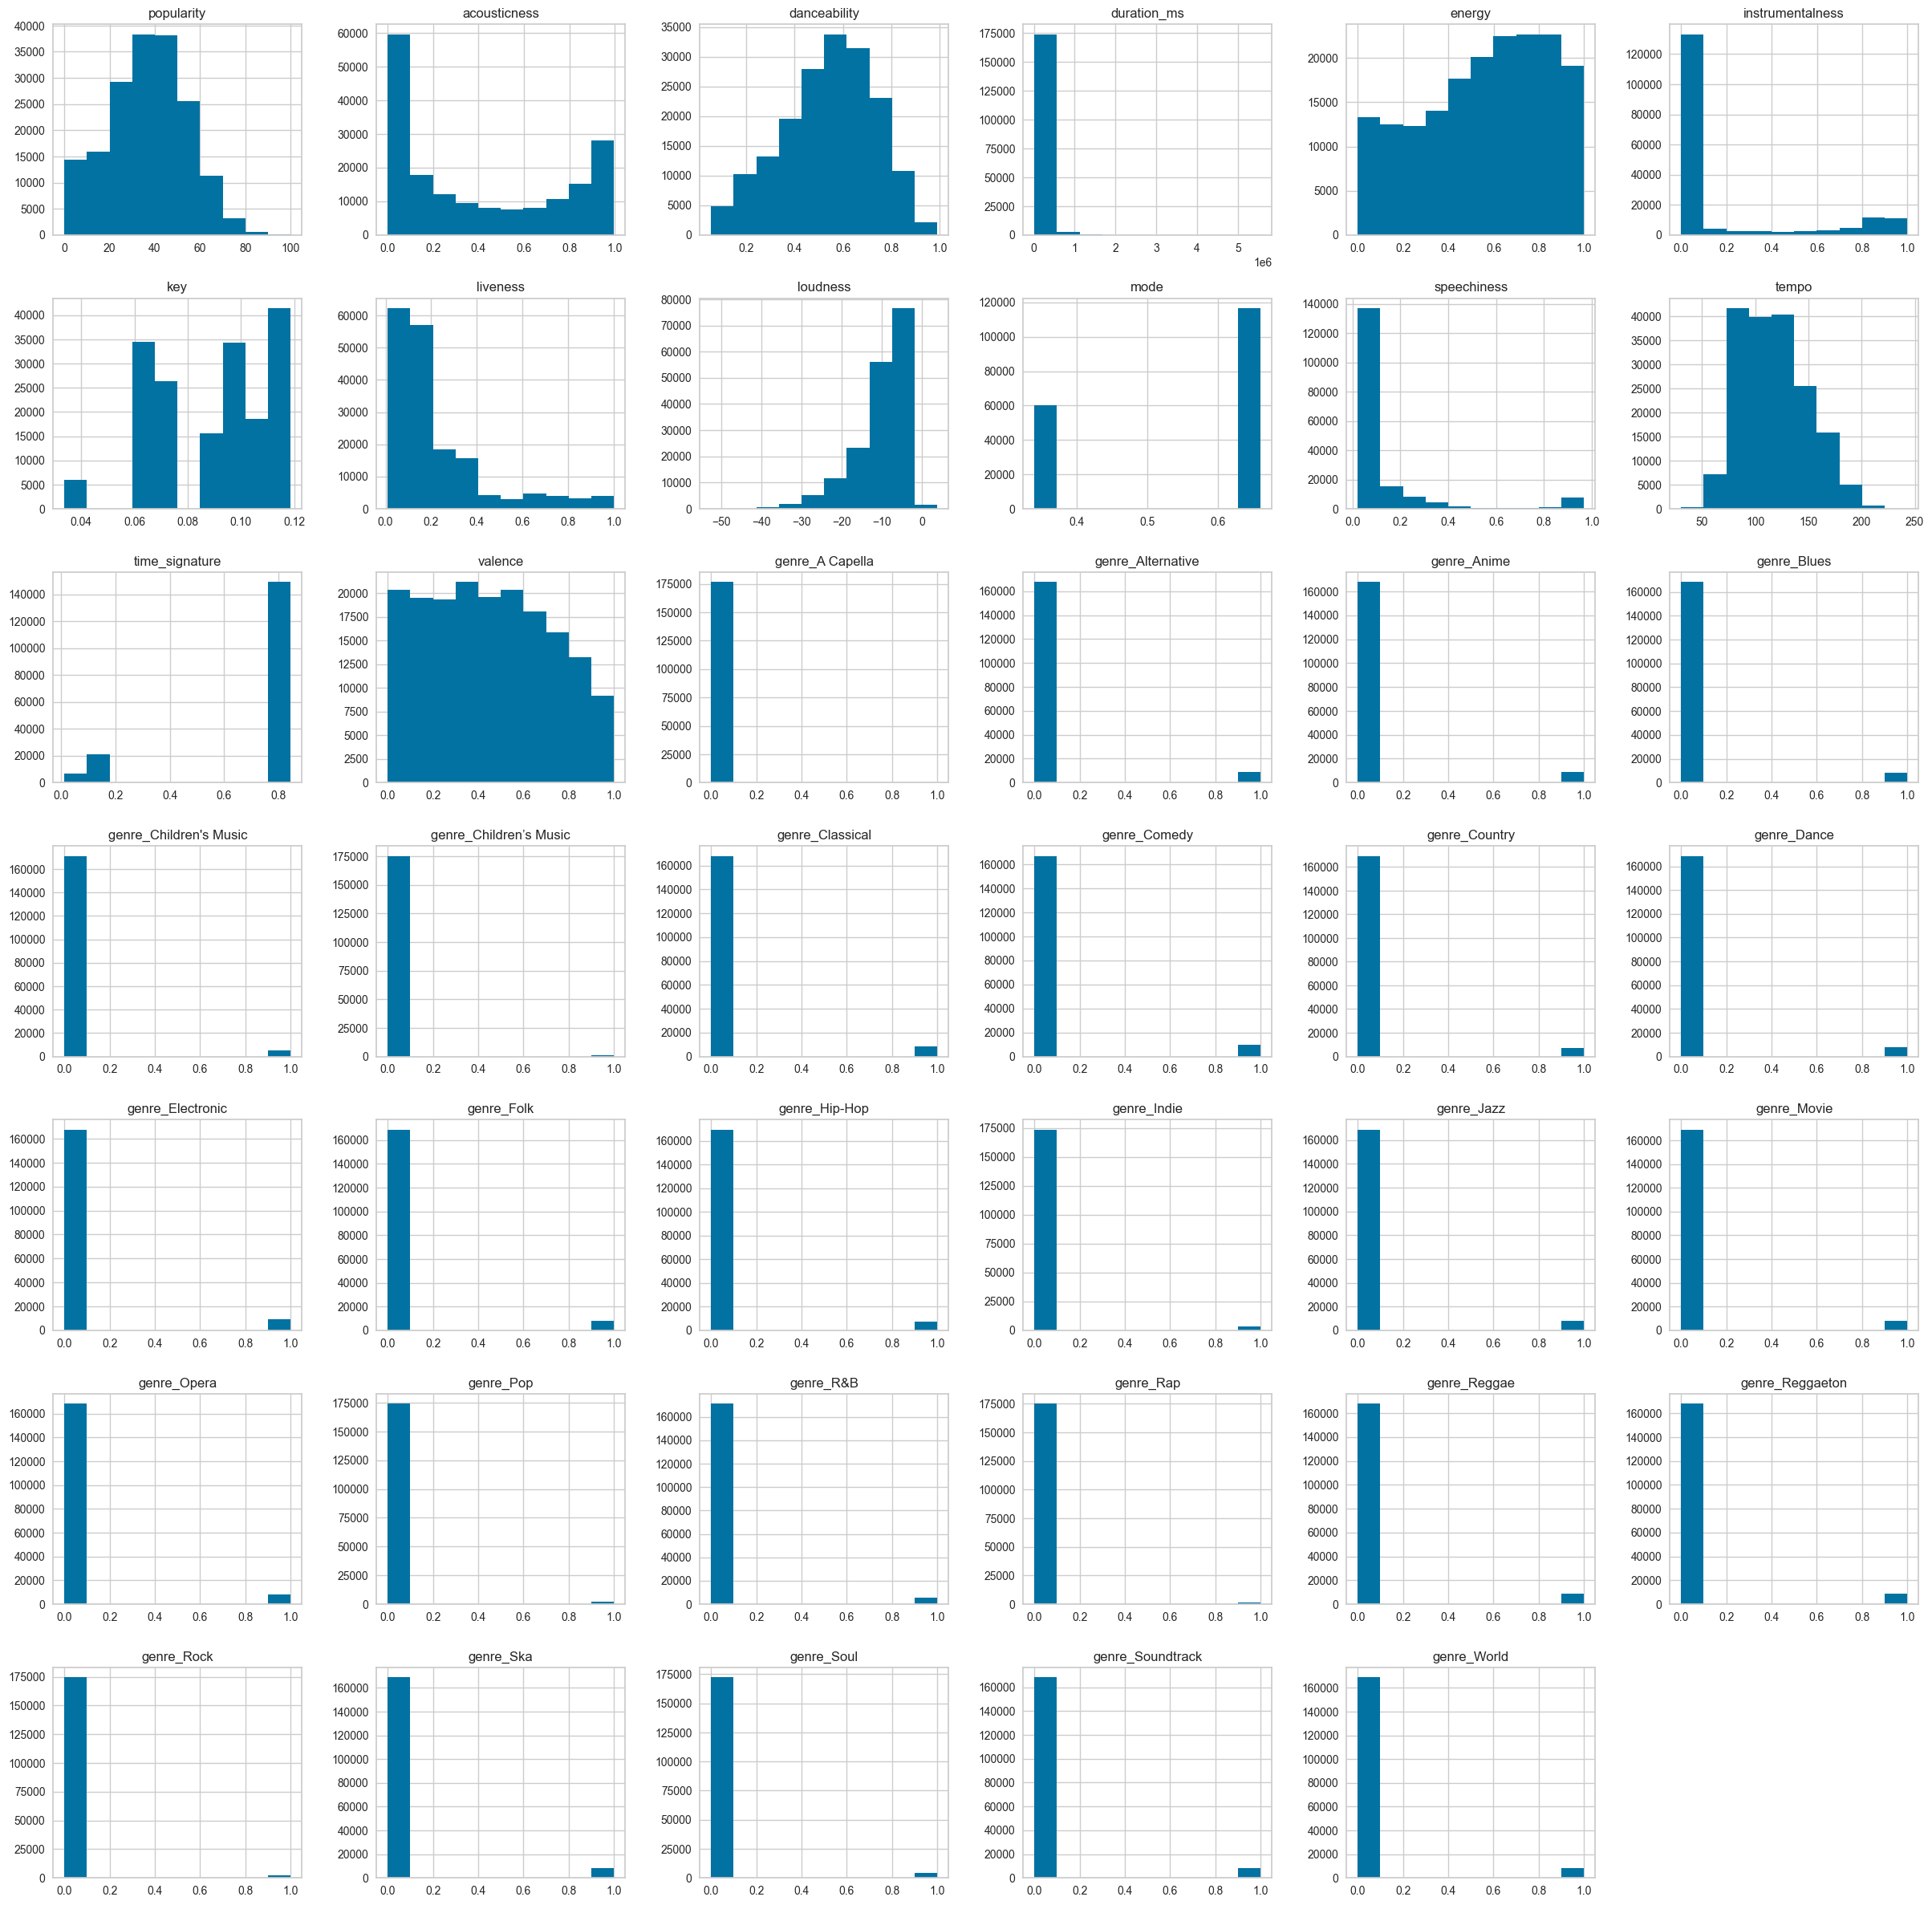

In [7]:
#5) Mirar dist
df1.hist(figsize=(30, 30)), df2.hist(figsize=(30, 30)), df3.hist(figsize=(30, 30)), 

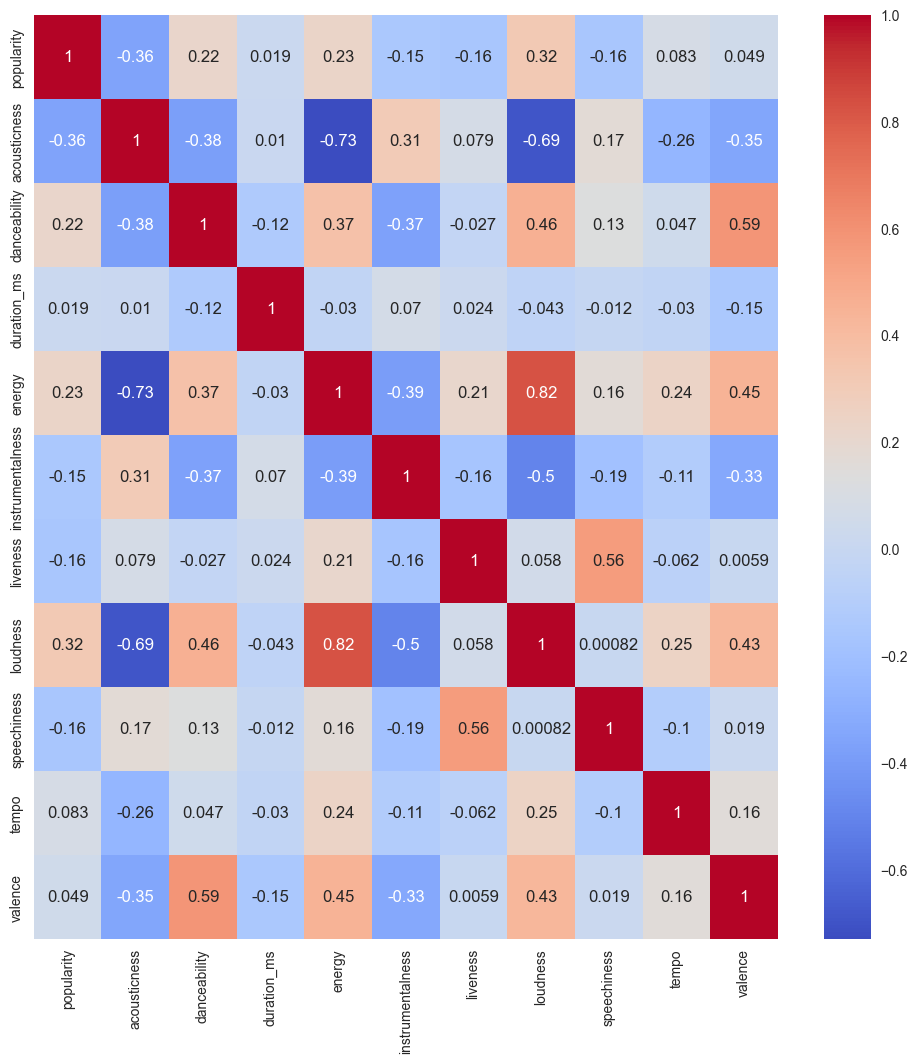

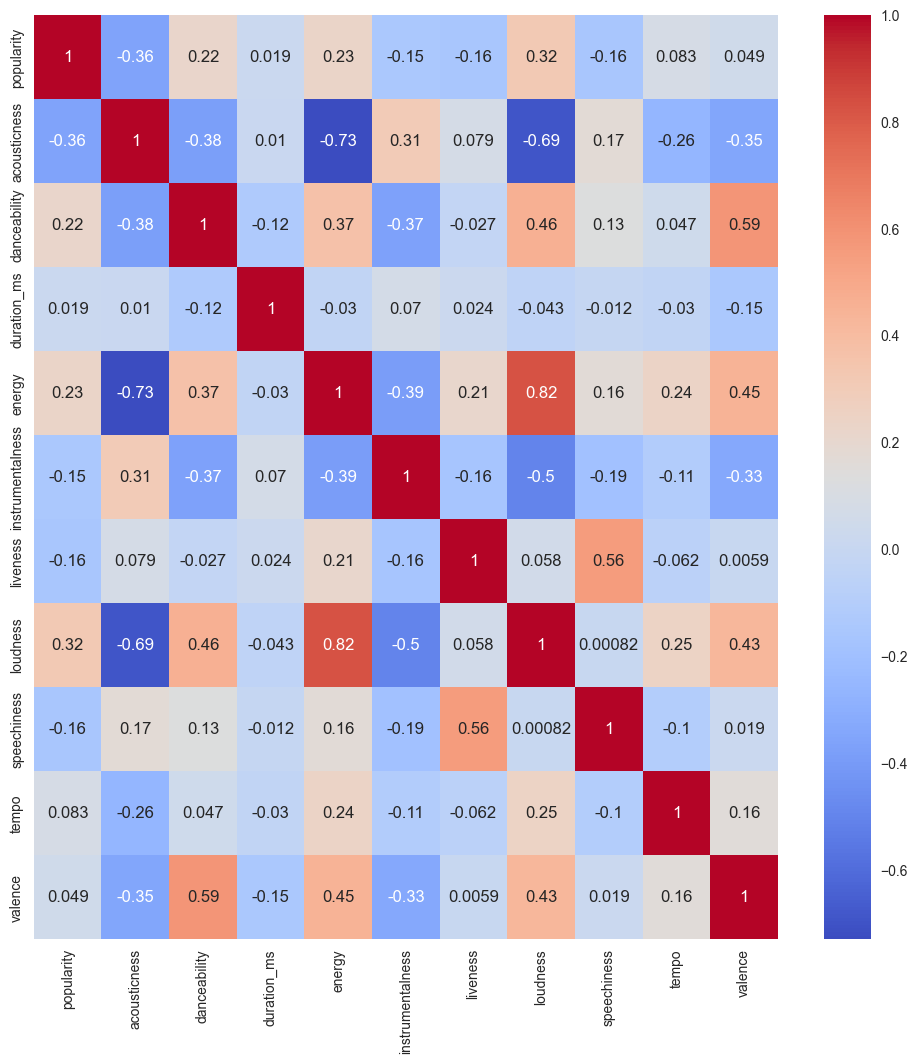

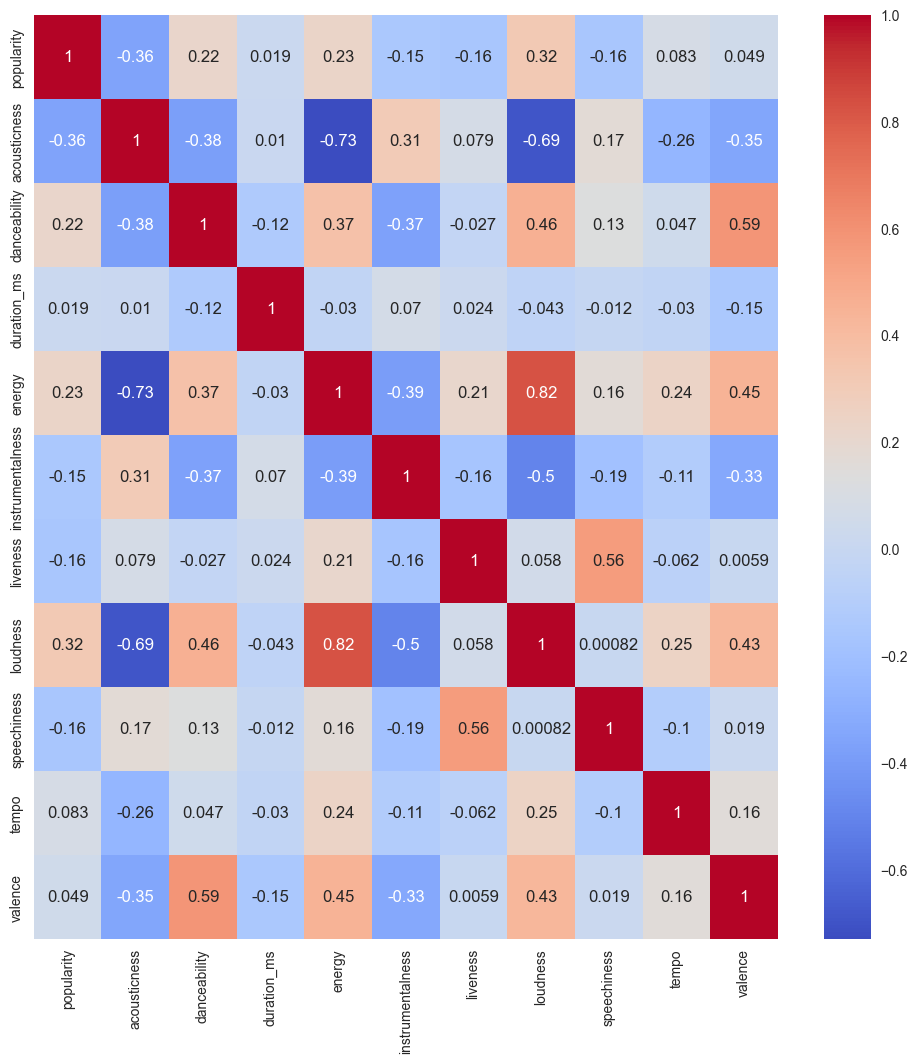

In [8]:
#6) Mirar correlació (pearson)
corr_matrix1 = df1[num_col].corr()
plt.figure(figsize=(12, 12))
ax = sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm')
plt.show()

corr_matrix2 = df2[num_col].corr()
plt.figure(figsize=(12, 12))
ax = sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm')
plt.show()

corr_matrix3 = df3[num_col].corr()
plt.figure(figsize=(12, 12))
ax = sns.heatmap(corr_matrix3, annot=True, cmap='coolwarm')
plt.show()

In [9]:
#6) Escalar columnes
scaler = StandardScaler()
df1_scal = scaler.fit_transform(df1)
df2_scal = scaler.fit_transform(df2)
df3_scal = scaler.fit_transform(df3)
#data_scal = pd.DataFrame(data=scaler.fit_transform(data), columns=data.columns)

# D) Establir model

## 1) KMeans

Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\gaofu\anaconda3\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\gaofu\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\gaofu\anaconda3\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\gaofu\anaconda3\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa2 in position 116: invalid start byte


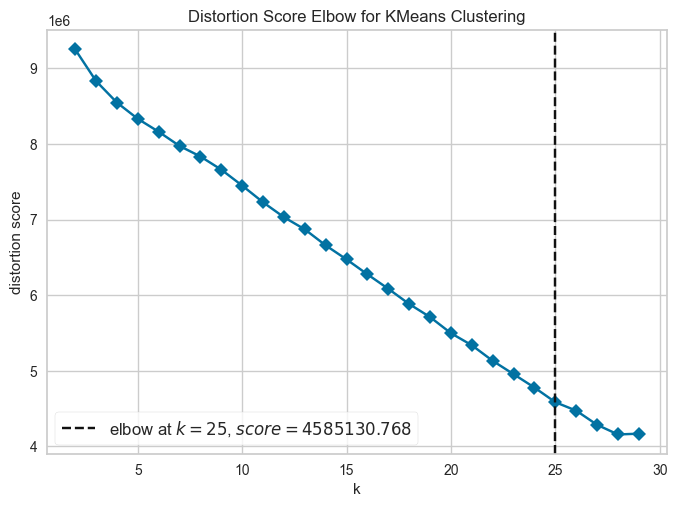

In [10]:
#DATASET1
#1) Calcular k millor
model = KMeans(n_init=10, random_state=0)
visualizer = KElbowVisualizer(model, k=(2,30), timings=False, metric='distortion')
visualizer.fit(df1_scal)       
visualizer.show() #Quitar en py
k = visualizer.elbow_value_ #millor k

#2) Entrenar i predir amb KMEANS
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
#kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=0)
kmeans1 = kmeans.fit_predict(df1_scal) #Mateix que: kmeans.labels__
#data_scal["cluster"] = pred

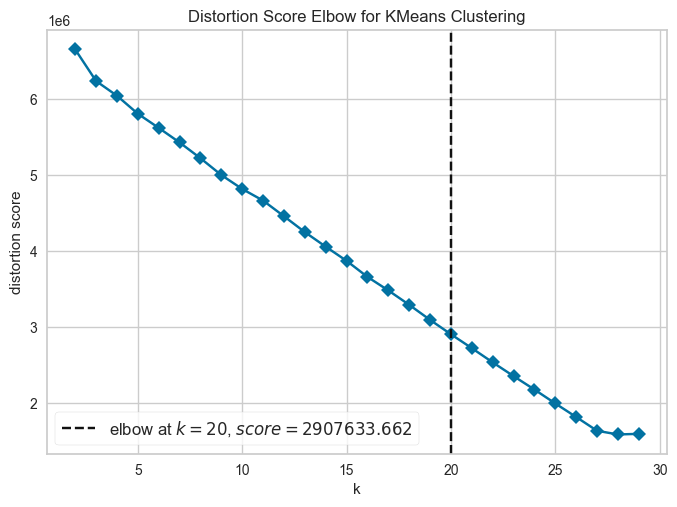

In [11]:
#DATASET2
#1) Calcular k millor
model = KMeans(n_init=10, random_state=0)
visualizer = KElbowVisualizer(model, k=(2,30), timings=False, metric='distortion')
visualizer.fit(df2_scal)       
visualizer.show() #Quitar en py
k = visualizer.elbow_value_ #millor k

#2) Entrenar i predir amb KMEANS
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
#kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=0)
kmeans2 = kmeans.fit_predict(df2_scal) #Mateix que: kmeans.labels__
#data_scal["cluster"] = pred

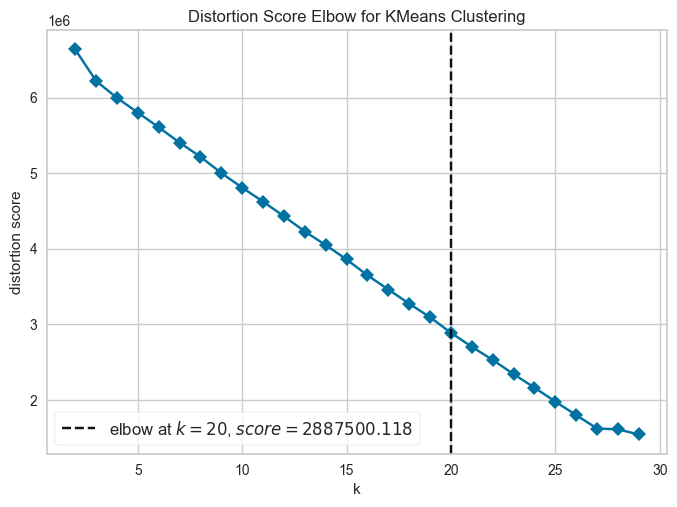

In [12]:
#DATASET3
#1) Calcular k millor
model = KMeans(n_init=10, random_state=0)
visualizer = KElbowVisualizer(model, k=(2,30), timings=False, metric='distortion')
visualizer.fit(df3_scal)       
visualizer.show() #Quitar en py
k = visualizer.elbow_value_ #millor k

#2) Entrenar i predir amb KMEANS
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
#kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=0)
kmeans3 = kmeans.fit_predict(df3_scal) #Mateix que: kmeans.labels__
#data_scal["cluster"] = pred

## 2) Minibatch

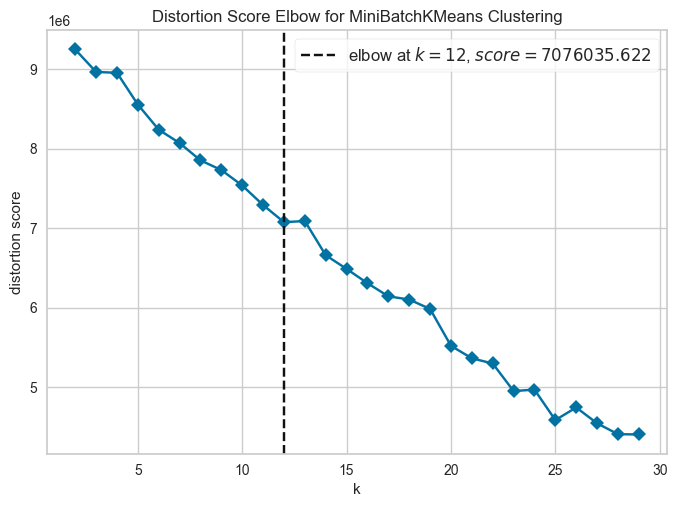

In [13]:
#DATASET1
#1) Calcular k millor
model = MiniBatchKMeans(n_init=10, random_state=0)
visualizer = KElbowVisualizer(model, k=(2,30), timings=False, metric='distortion')
visualizer.fit(df1_scal)       
visualizer.show() #Quitar en py
k = visualizer.elbow_value_ #millor k

#2) Entrenar i predir amb KMEANS
kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=0)
#kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=0)
mini1 = kmeans.fit_predict(df1_scal) #Mateix que: kmeans.labels__
#data_scal["cluster"] = pred

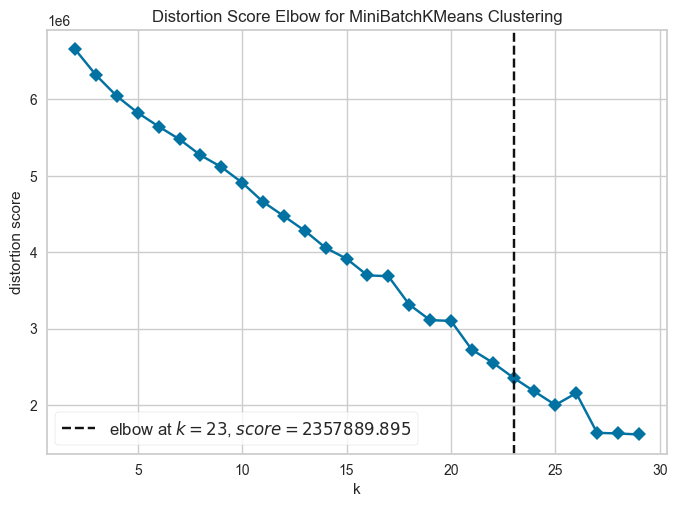

In [14]:
#DATASET2
#1) Calcular k millor
model = MiniBatchKMeans(n_init=10, random_state=0)
visualizer = KElbowVisualizer(model, k=(2,30), timings=False, metric='distortion')
visualizer.fit(df2_scal)       
visualizer.show() #Quitar en py
k = visualizer.elbow_value_ #millor k

#2) Entrenar i predir amb KMEANS
kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=0)
#kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=0)
mini2 = kmeans.fit_predict(df2_scal) #Mateix que: kmeans.labels__
#data_scal["cluster"] = pred

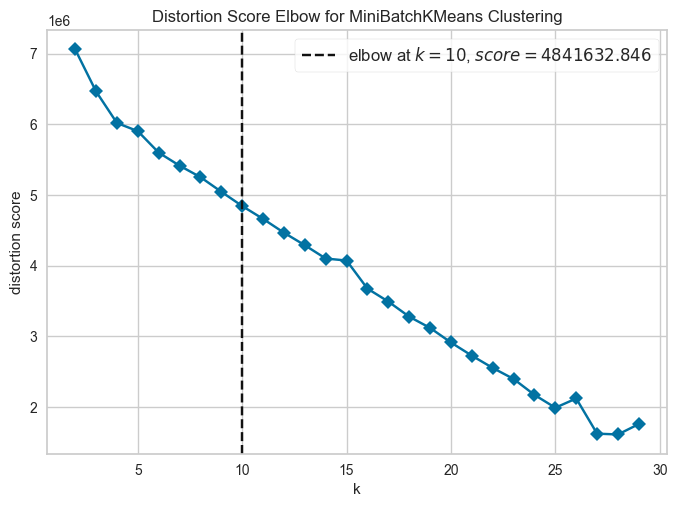

In [15]:
#DATASET3
#1) Calcular k millor
model = MiniBatchKMeans(n_init=10, random_state=0)
visualizer = KElbowVisualizer(model, k=(2,30), timings=False, metric='distortion')
visualizer.fit(df3_scal)       
visualizer.show() #Quitar en py
k = visualizer.elbow_value_ #millor k

#2) Entrenar i predir amb KMEANS
kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=0)
#kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=0)
mini3 = kmeans.fit_predict(df3_scal) #Mateix que: kmeans.labels__
#data_scal["cluster"] = pred

## 3) DBSCAN

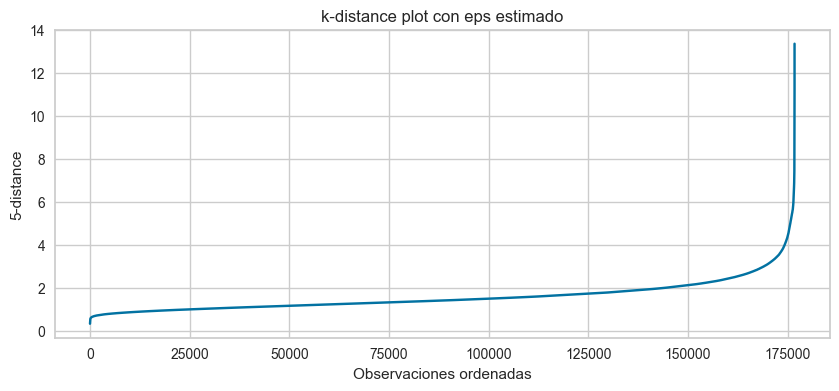

In [16]:
#DATASET1
#1) Calcular eps
k = 5
nn = NearestNeighbors(n_neighbors=k).fit(df1_scal)
dists, _ = nn.kneighbors(df1_scal)
kdist = np.sort(dists[:, -1])
plt.figure(figsize=(10,4))
plt.plot(kdist, label=f'{k}-distance sorted')
plt.title('k-distance plot con eps estimado')
plt.xlabel('Observaciones ordenadas')
plt.ylabel(f'{k}-distance')
min_samples = 2 * df1_scal.shape[1] - 25
plt.show()

In [17]:
#2) Entrenar i predir amb DBSCAN
db = DBSCAN(eps=4.0, min_samples=min_samples, n_jobs=-1,)
dbscan1 = db.fit_predict(df1_scal)

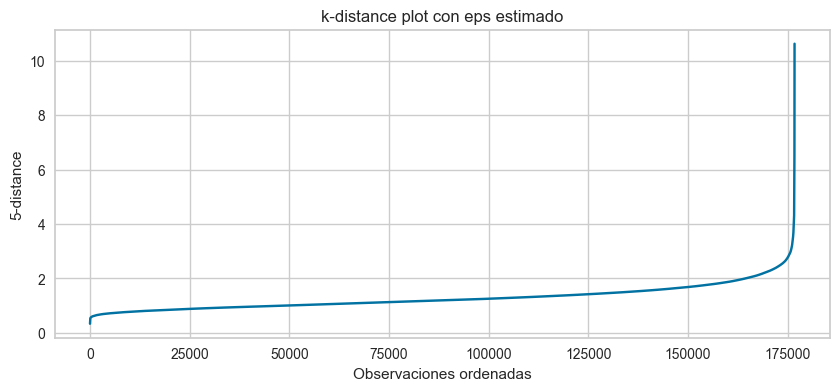

In [ ]:
#DATASET2
#1) Calcular eps
k = 5
nn = NearestNeighbors(n_neighbors=k).fit(df2_scal)
dists, _ = nn.kneighbors(df2_scal)
kdist = np.sort(dists[:, -1])
plt.figure(figsize=(10,4))
plt.plot(kdist, label=f'{k}-distance sorted')
plt.title('k-distance plot con eps estimado')
plt.xlabel('Observaciones ordenadas')
plt.ylabel(f'{k}-distance')
min_samples = 2 * df2_scal.shape[1] - 25
plt.show()

In [19]:
#2) Entrenar i predir amb DBSCAN
db = DBSCAN(eps=2.9, min_samples=min_samples, n_jobs=-1,)
dbscan2 = db.fit_predict(df2_scal)

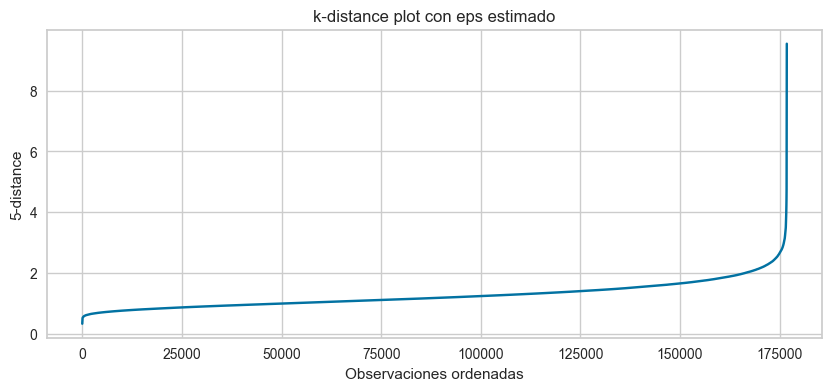

In [22]:
#DATASET3
#1) Calcular eps
k = 5
nn = NearestNeighbors(n_neighbors=k).fit(df3_scal)
dists, _ = nn.kneighbors(df3_scal)
kdist = np.sort(dists[:, -1])
plt.figure(figsize=(10,4))
plt.plot(kdist, label=f'{k}-distance sorted')
plt.title('k-distance plot con eps estimado')
plt.xlabel('Observaciones ordenadas')
plt.ylabel(f'{k}-distance')
min_samples = 2 * df3_scal.shape[1] - 25
plt.show()

In [32]:
#2) Entrenar i predir amb DBSCAN
db = DBSCAN(eps=2.6, min_samples=min_samples, n_jobs=-1,)
dbscan3 = db.fit_predict(df3_scal)

## 4) HDBSCAN

In [34]:
#DATASET1
#1) Entrenar i predir amb HDBSCAN
min_samples = 2 * df1_scal.shape[1] - 25
db = HDBSCAN(min_cluster_size=min_samples, n_jobs=-1)
hdbscan1 = db.fit_predict(df1_scal)

In [35]:
#DATASET2
#1) Entrenar i predir amb HDBSCAN
min_samples = 2 * df2_scal.shape[1] - 25
db = HDBSCAN(min_cluster_size=min_samples, n_jobs=-1)
hdbscan2 = db.fit_predict(df2_scal)

In [36]:
#DATASET3
#1) Entrenar i predir amb HDBSCAN
min_samples = 2 * df3_scal.shape[1] - 25
db = HDBSCAN(min_cluster_size=min_samples, n_jobs=-1)
hdbscan3 = db.fit_predict(df3_scal)

## 5) Gaussian Mixture

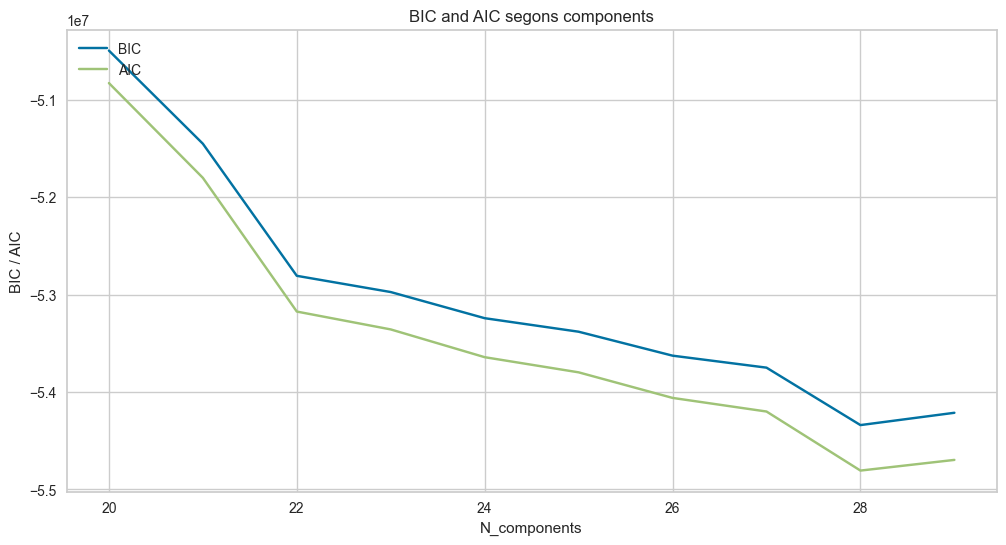

In [ ]:
#DATASET1
#1) Trobar n_components
n_components_range = range(20,30)
bics = []
aics = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, n_init=10, random_state=0)
    gmm.fit(df1_scal)
    bics.append(gmm.bic(df1_scal))
    aics.append(gmm.aic(df1_scal))

plt.figure(figsize=(12, 6))
plt.plot(n_components_range, bics, label='BIC')
plt.plot(n_components_range, aics, label='AIC')
plt.xlabel('N_components')
plt.ylabel('BIC / AIC')
plt.legend(loc=1, bbox_to_anchor=(1.2, 1))
plt.title('BIC and AIC segons components')
plt.show()

In [37]:
#2) Entrenar i predir amb GM
gm = GaussianMixture(n_components=25, n_init=10, random_state=0)
gm1 = gm.fit_predict(df1_scal)

In [ ]:
#DATASET2
#1) Trobar n_components
n_components_range = range()
bics = []
aics = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, n_init=10, random_state=0)
    gmm.fit(df1_scal)
    bics.append(gmm.bic(df2_scal))
    aics.append(gmm.aic(df2_scal))

plt.figure(figsize=(12, 6))
plt.plot(n_components_range, bics, label='BIC')
plt.plot(n_components_range, aics, label='AIC')
plt.xlabel('N_components')
plt.ylabel('BIC / AIC')
plt.legend(loc=2)
plt.title('BIC and AIC segons components')
plt.show()

In [38]:
#2) Entrenar i predir amb GM
gm = GaussianMixture(n_components=20, n_init=10, random_state=0)
gm2 = gm.fit_predict(df2_scal)

In [39]:
#DATASET3
#2) Entrenar i predir amb GM
gm = GaussianMixture(n_components=20, n_init=10, random_state=0)
gm3 = gm.fit_predict(df3_scal)

# E) Evaluar models

In [40]:
#KMEANS
print(calinski_harabasz_score(df1_scal, kmeans1), davies_bouldin_score(df1_scal, kmeans1))
print(calinski_harabasz_score(df2_scal, kmeans2), davies_bouldin_score(df2_scal, kmeans2))
print(calinski_harabasz_score(df3_scal, kmeans3), davies_bouldin_score(df3_scal, kmeans3))

8534.611112234576 1.430182296326957
13884.486169915781 1.5675783277657818
14046.160854717451 1.611511491975799


In [41]:
#Minibatch
print(calinski_harabasz_score(df1_scal, mini1), davies_bouldin_score(df1_scal, mini1))
print(calinski_harabasz_score(df2_scal, mini2), davies_bouldin_score(df2_scal, mini2))
print(calinski_harabasz_score(df3_scal, mini3), davies_bouldin_score(df3_scal, mini3))

6410.427982668457 2.349968314074333
16659.731587568556 1.3229997114681058
9758.977924160143 2.1654833427001177


In [42]:
#DBSCAN
print(calinski_harabasz_score(df1_scal, dbscan1), davies_bouldin_score(df1_scal, dbscan1))
print(calinski_harabasz_score(df2_scal, dbscan2), davies_bouldin_score(df2_scal, dbscan2))
print(calinski_harabasz_score(df3_scal, dbscan3), davies_bouldin_score(df3_scal, dbscan3))

1307.2972420083065 1.515334713977128
17958.325770011626 1.7576726190995868
11453.600872503672 1.8624532092401223


In [43]:
#HDBSCAN
print(calinski_harabasz_score(df1_scal, hdbscan1), davies_bouldin_score(df1_scal, hdbscan1))
print(calinski_harabasz_score(df2_scal, hdbscan2), davies_bouldin_score(df2_scal, hdbscan2))
print(calinski_harabasz_score(df3_scal, hdbscan3), davies_bouldin_score(df3_scal, hdbscan3))

1623.7741566804336 1.4538624609479567
19953.038549644 1.1791012357208133
21334.476413418743 1.3474740552698885


In [44]:
#GaussianMixture
print(calinski_harabasz_score(df1_scal, gm1), davies_bouldin_score(df1_scal, gm1))
print(calinski_harabasz_score(df2_scal, gm2), davies_bouldin_score(df2_scal, gm2))
print(calinski_harabasz_score(df3_scal, gm3), davies_bouldin_score(df3_scal, gm3))

7359.812365158404 1.9146044102748476
13697.517854706604 1.4767594853115569
13721.123415578986 1.3884568203133252


# F) Visualitzar predicció

In [64]:
# Crear sampled dataset per proves més ràpides
# Samplearem 25% de les dades per a proves
sample_size = int(len(df) * 0.15)
sample_indices = np.random.RandomState(42).choice(len(df), sample_size, replace=False)

df1_sample = df1_scal[sample_indices]
df2_sample = df2_scal[sample_indices]
df3_sample = df3_scal[sample_indices]

#pred= pred[sample_indices]
print("Mida orignal:", df.shape)
print("Mida 20%:", df1_sample.shape)

Mida orignal: (176767, 15)
Mida 20%: (26515, 56)


## 1) HDBSCAN

In [ ]:
#DATASET1
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. PCA Estàndard
pca_sample = PCA(n_components=2, random_state=42)
df1_sample_pca = pca_sample.fit_transform(df1_sample)

df1_sample_pca_2 = pd.DataFrame(data=df1_sample_pca, columns=['Component 1', 'Component 2'])
df1_sample_pca_2["Cluster"] = hdbscan1[sample_indices]
sns.scatterplot(data=df1_sample_pca_2, x='Component 1', y='Component 2', hue='Cluster', 
               palette='tab20', ax=axes[0, 0])
axes[0, 0].set_title('PCA Estàndard (DF1)')
axes[0, 0].legend(loc=2, bbox_to_anchor=(-0.3, 1))

# 2. KernelPCA RBF
kpca_sample = KernelPCA(n_components=2, kernel='rbf', random_state=42, n_jobs=-1)
df1_sample_kpca = kpca_sample.fit_transform(df1_sample)

df1_sample_kpca_2 = pd.DataFrame(data=df1_sample_kpca, columns=['Component 1', 'Component 2'])
df1_sample_kpca_2["Cluster"] = hdbscan1[sample_indices]
sns.scatterplot(data=df1_sample_kpca_2, x='Component 1', y='Component 2', hue='Cluster', 
               palette='tab20', ax=axes[0, 1])
axes[0, 1].set_title('KernelPCA RBF (DF1)')
axes[0, 1].legend(loc=1, bbox_to_anchor=(1.2, 1))

# 3. TruncatedSVD
tsvd_sample = TruncatedSVD(n_components=2, random_state=42)
df1_sample_tsvd = tsvd_sample.fit_transform(df1_sample)

df1_sample_tsvd_2 = pd.DataFrame(data=df1_sample_tsvd, columns=['Component 1', 'Component 2'])
df1_sample_tsvd_2["Cluster"] = hdbscan1[sample_indices]
sns.scatterplot(data=df1_sample_tsvd_2, x='Component 1', y='Component 2', hue='Cluster', 
               palette='tab20', ax=axes[1, 0])
axes[1, 0].set_title('TruncatedSVD (DF1)')
axes[1, 0].legend(loc=2, bbox_to_anchor=(-0.3, 1))

# 4. TSNE
tsne = TSNE(n_components=2, perplexity=50, learning_rate='auto', random_state=42)
df1_sample_tsne = tsne.fit_transform(df1_sample)
df1_sample_tsne_2 = pd.DataFrame(data=df1_sample_tsne, columns=['Component 1', 'Component 2'])
df1_sample_tsne_2["Cluster"] = hdbscan1[sample_indices]

sns.scatterplot(data=df1_sample_tsne_2, x='Component 1', y='Component 2', hue='Cluster',
               palette='tab20', ax=axes[1, 1])
axes[1, 1].set_title('TSNE (DF1)')
axes[1, 1].legend(loc=1, bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.legend(loc=1, bbox_to_anchor=(1.2, 1))
plt.show()

In [ ]:
#DATASET2
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. PCA Estàndard
pca_sample = PCA(n_components=2, random_state=42)
df2_sample_pca = pca_sample.fit_transform(df2_sample)

df2_sample_pca_2 = pd.DataFrame(data=df2_sample_pca, columns=['Component 1', 'Component 2'])
df2_sample_pca_2["Cluster"] = hdbscan2[sample_indices]
sns.scatterplot(data=df2_sample_pca_2, x='Component 1', y='Component 2', hue='Cluster', 
               palette='tab20', ax=axes[0, 0])
axes[0, 0].set_title('PCA Estàndard (DF2)')
axes[0, 0].legend(loc=2, bbox_to_anchor=(-0.2, 1))

# 2. KernelPCA RBF
kpca_sample = KernelPCA(n_components=2, kernel='rbf', random_state=42, n_jobs=-1)
df2_sample_kpca = kpca_sample.fit_transform(df2_sample)

df2_sample_kpca_2 = pd.DataFrame(data=df2_sample_kpca, columns=['Component 1', 'Component 2'])
df2_sample_kpca_2["Cluster"] = hdbscan2[sample_indices]
sns.scatterplot(data=df2_sample_kpca_2, x='Component 1', y='Component 2', hue='Cluster', 
               palette='tab20', ax=axes[0, 1])
axes[0, 1].set_title('KernelPCA RBF (DF2)')
axes[0, 1].legend(loc=1, bbox_to_anchor=(1.2, 1))

# 3. TruncatedSVD
tsvd_sample = TruncatedSVD(n_components=2, random_state=42)
df2_sample_tsvd = tsvd_sample.fit_transform(df2_sample)

df2_sample_tsvd_2 = pd.DataFrame(data=df2_sample_tsvd, columns=['Component 1', 'Component 2'])
df2_sample_tsvd_2["Cluster"] = hdbscan2[sample_indices]
sns.scatterplot(data=df2_sample_tsvd_2, x='Component 1', y='Component 2', hue='Cluster', 
               palette='tab20', ax=axes[1, 0])
axes[1, 0].set_title('TruncatedSVD (DF2)')
axes[1, 0].legend(loc=2, bbox_to_anchor=(-0.2, 1))

# 4. TSNE
tsne = TSNE(n_components=2, perplexity=50, learning_rate='auto', random_state=42)
df2_sample_tsne = tsne.fit_transform(df2_sample)
df2_sample_tsne_2 = pd.DataFrame(data=df2_sample_tsne, columns=['Component 1', 'Component 2'])
df2_sample_tsne_2["Cluster"] = hdbscan2[sample_indices]

sns.scatterplot(data=df2_sample_tsne_2, x='Component 1', y='Component 2', hue='Cluster',
               palette='tab20', ax=axes[1, 1])
axes[1, 1].set_title('TSNE (DF2)')
axes[1, 1].legend(loc=1, bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.show()

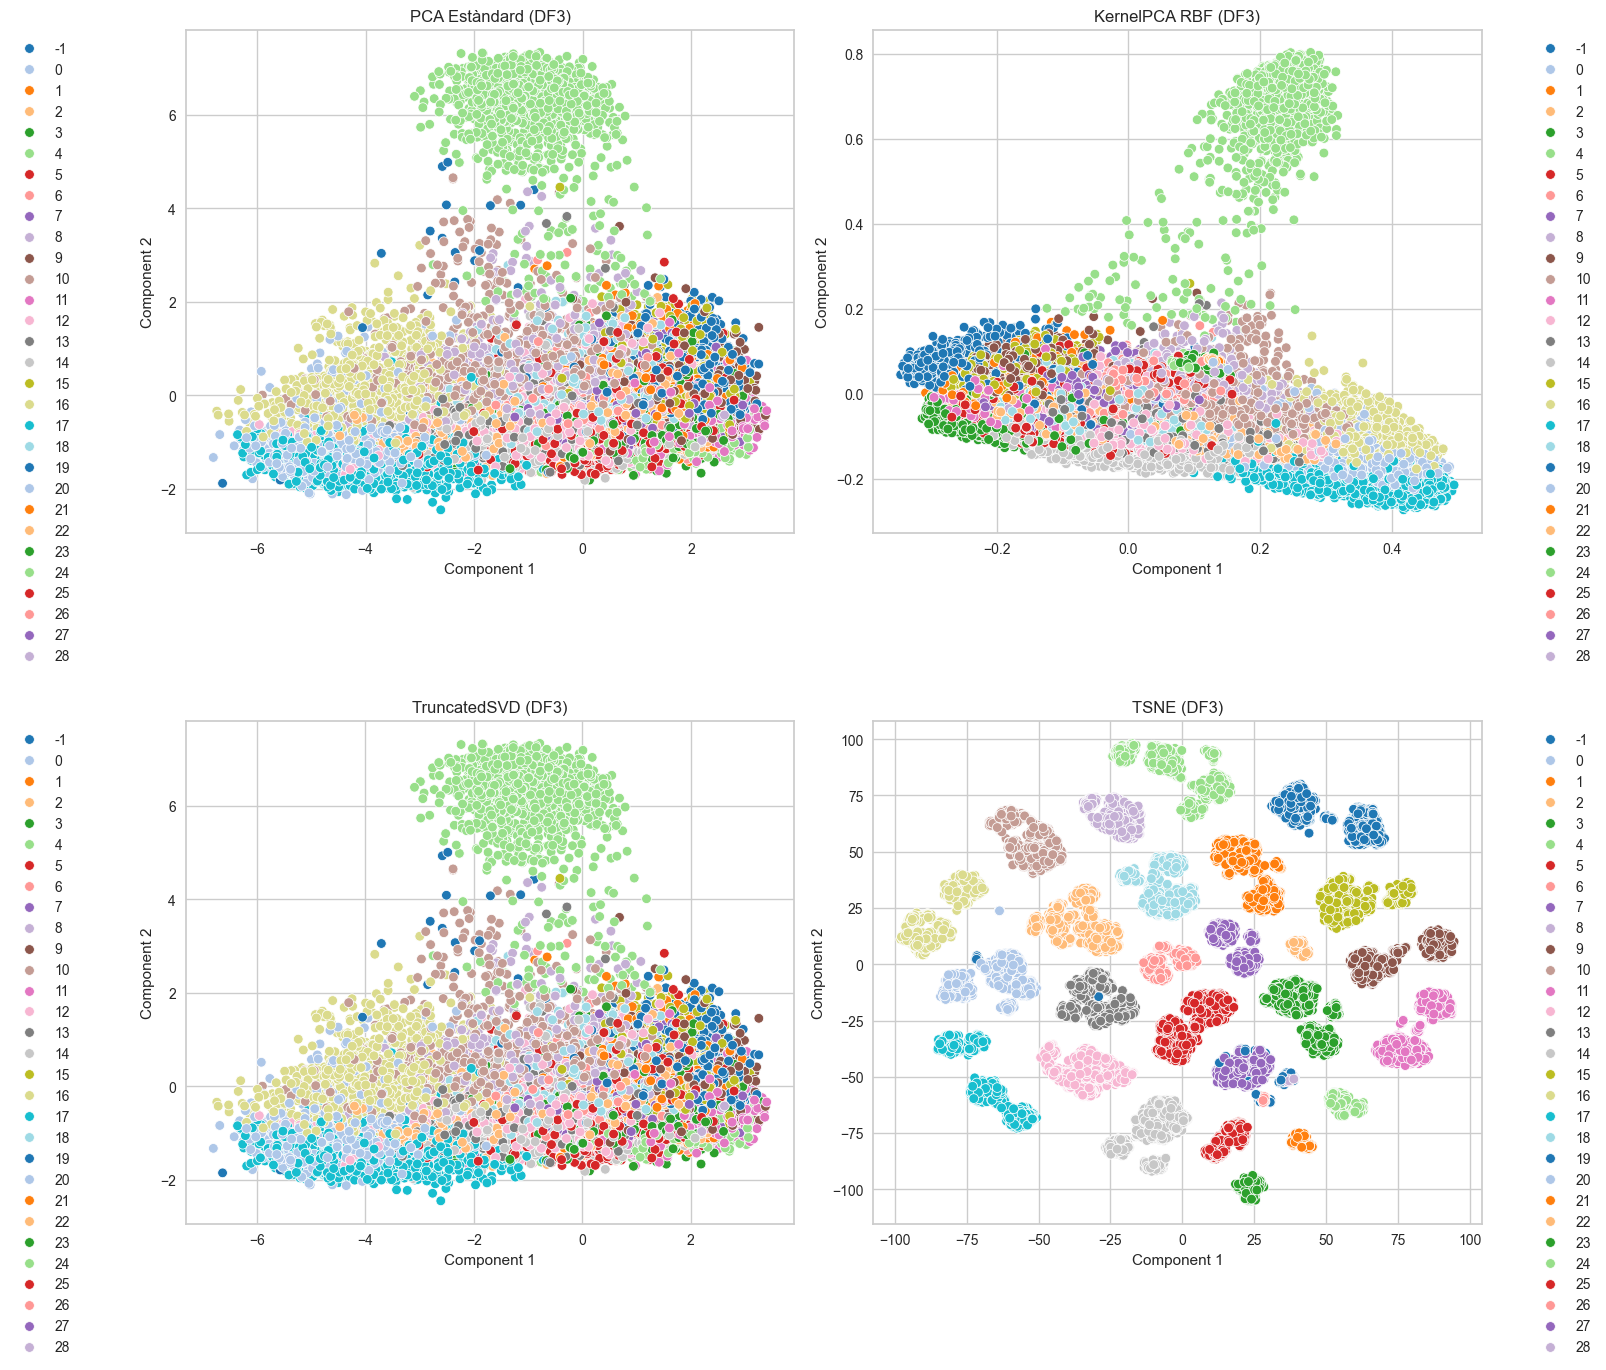

In [58]:
#DATASET3
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. PCA Estàndard
pca_sample = PCA(n_components=2, random_state=42)
df3_sample_pca = pca_sample.fit_transform(df3_sample)

df3_sample_pca_2 = pd.DataFrame(data=df3_sample_pca, columns=['Component 1', 'Component 2'])
df3_sample_pca_2["Cluster"] = hdbscan3[sample_indices]
sns.scatterplot(data=df3_sample_pca_2, x='Component 1', y='Component 2', hue='Cluster', 
               palette='tab20', ax=axes[0, 0])
axes[0, 0].set_title('PCA Estàndard (DF3)')
axes[0, 0].legend(loc=2, bbox_to_anchor=(-0.3, 1))

# 2. KernelPCA RBF
kpca_sample = KernelPCA(n_components=2, kernel='rbf', random_state=42, n_jobs=-1)
df3_sample_kpca = kpca_sample.fit_transform(df3_sample)

df3_sample_kpca_2 = pd.DataFrame(data=df3_sample_kpca, columns=['Component 1', 'Component 2'])
df3_sample_kpca_2["Cluster"] = hdbscan3[sample_indices]
sns.scatterplot(data=df3_sample_kpca_2, x='Component 1', y='Component 2', hue='Cluster', 
               palette='tab20', ax=axes[0, 1])
axes[0, 1].set_title('KernelPCA RBF (DF3)')
axes[0, 1].legend(loc=1, bbox_to_anchor=(1.2, 1))

# 3. TruncatedSVD
tsvd_sample = TruncatedSVD(n_components=2, random_state=42)
df3_sample_tsvd = tsvd_sample.fit_transform(df3_sample)

df3_sample_tsvd_2 = pd.DataFrame(data=df3_sample_tsvd, columns=['Component 1', 'Component 2'])
df3_sample_tsvd_2["Cluster"] = hdbscan3[sample_indices]
sns.scatterplot(data=df3_sample_tsvd_2, x='Component 1', y='Component 2', hue='Cluster', 
               palette='tab20', ax=axes[1, 0])
axes[1, 0].set_title('TruncatedSVD (DF3)')
axes[1, 0].legend(loc=2, bbox_to_anchor=(-0.3, 1))

# 4. TSNE
tsne = TSNE(n_components=2, perplexity=50, learning_rate='auto', random_state=42)
df3_sample_tsne = tsne.fit_transform(df3_sample)
df3_sample_tsne_2 = pd.DataFrame(data=df3_sample_tsne, columns=['Component 1', 'Component 2'])
df3_sample_tsne_2["Cluster"] = hdbscan3[sample_indices]

sns.scatterplot(data=df3_sample_tsne_2, x='Component 1', y='Component 2', hue='Cluster',
               palette='tab20', ax=axes[1, 1])
axes[1, 1].set_title('TSNE (DF3)')
axes[1, 1].legend(loc=1, bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.legend(loc=1, bbox_to_anchor=(1.2, 1))
plt.show()

# G) Random songs

In [ ]:
cluster_labels = sorted([label for label in set(hdbscan3) if label != -1]) #totes les labels del model
sizes = {label: int((hdbscan3 == label).sum()) for label in cluster_labels} #quanitat de cancos en cada label

random_index = np.random.RandomState(42).randint(len(df3_scal)) #index de canço random
random_label = hdbscan3[random_index] #label de canço random

cluster_index = np.where(hdbscan3 == random_label)[0] #index de cancons amb label de canço random 

recomancio = 2
random_recomancio_index = np.random.RandomState(42).choice(cluster_index, size=recomancio, replace=False) #index de 

print("Nom canço:", track_name.iloc[random_index].values)
print("Nom artista:", artist_name.iloc[random_index].values)
print("Label:", hdbscan3[random_index])
print("Cançons disponibles:", sizes[random_label])

for i in range(recomancio): 
    print("RECOMANCIO", i)
    print("Nom canço:", track_name.iloc[random_recomancio_index[i]].values)
    print("Nom artista:", artist_name.iloc[random_recomancio_index[i]].values)
    print("Label:", hdbscan3[random_recomancio_index[i]])

Nom canço: ['Donde Esta Mi Gata']
Nom artista: ['Yandel']
Label: 19
Cançons disponibles: 8536
RECOMANCIO 0
Nom canço: ['Mi Amor']
Nom artista: ['Grupo Treo']
Label: 19
RECOMANCIO 1
Nom canço: ['Suave Y Lento']
Nom artista: ['Jowell & Randy']
Label: 19
